In [1]:
# import cudf as pd
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
# df = pd.read_csv("llamacpp.llama8b.trace.3conversation_no_cachedrop.log)
# df = pd.read_csv("results/retval/llamacpp.llama8b.trace.1717683027-1talk.log")
# df = pd.read_csv("results/retval/llamacpp.llama8b.trace.1717683171-3talk.log")
df = pd.read_csv("results/retval/with_prefetch/llamacpp.llama70b.trace.1718678698-only_load_model_time.log")
df = df.dropna()

/tmp/ipykernel_3682426/4196374767.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("results/retval/with_prefetch/llamacpp.llama70b.trace.1718678698-only_load_model_time.log")


In [3]:
df['time'] = df["time"].astype("int")
df["flags"] = df["flags"].astype("int").parallel_apply(lambda x: f"{bin(x)[2:]}".ljust(10, "0")).astype("str")
df["retval"] = df["retval"].astype("int").parallel_apply(lambda x: f"{hex(x)}").astype("str")

In [4]:
df

,pid,name,addr,flags,time,retval
0,2888094,node,(nil),0000000000,412980113630501,0x0
1,2888094,node,0x219ab4131000,1001010101,4980,0x0
2,3680366,bpftrace,0x561d03371c60,1001010101,6030,0x0
3,3680374,bpftrace,0x7f17292eb080,1101010100,11250,0x100
4,3680374,bpftrace,0x7fffffffefea,1000000100,10850,0x0
...,...,...,...,...,...,...
1204894,3680374,sudo,0x5628434d1f68,1001010101,920,0x0
1204895,3680374,sudo,0x5628434c39b0,1001010101,900,0x0
1204896,3680374,sudo,0x7ff60cdfc350,1001010101,1200,0x0
1204897,3680374,sudo,0x7ff60cdff2c0,1001010101,980,0x0


In [5]:
df["name"].value_counts()

name
main               1028817
loginctl            103916
ps                   25665
node                 19542
cpuUsage.sh           9311
btop                  4406
cat                   4010
rustdesk              2164
systemd-journal       2130
sh                    1575
sed                    954
sudo                   624
which                  543
sleep                  493
git                    199
bash                   162
cpptools               109
cuda-EvtHandlr         103
zsh                     95
tailscaled              22
snapd                   14
rshim                   14
flexi_logger-fl         11
tokio-runtime-w          7
flexi_logger-fs          5
bpftrace                 4
in:imklog                2
containerd               1
Name: count, dtype: int64

In [6]:
# 过滤掉其他附带的程序
df = df[df["name"] == "main"]
df = df.reset_index().drop(columns=["index"])

In [7]:
df["name"].value_counts()

name
main    1028817
Name: count, dtype: int64

In [8]:
df["retval"].value_counts()

retval
0x100    764094
0x400    153140
0x0       62809
0x200     48308
0x404       466
Name: count, dtype: int64

# 虚拟地址转换成pfn

In [9]:
df["pfn"] = df["addr"].apply(lambda x: int(x, 16))
df["pfn"] = df["pfn"].parallel_apply(lambda x: (x - df["pfn"].min()) // (4 * 1024))
df["pfn"] = df["pfn"].astype("int")

In [10]:
df

,pid,name,addr,flags,time,retval,pfn
0,3680376,main,0x56102ca5a468,1000010101,508773,0x404,23100289114
1,3680376,main,0x56102ca5a468,1000110101,2920,0x200,23100289114
2,3680376,main,0x7fbc4ac7e110,1000010101,4950,0x200,34286621310
3,3680376,main,0x7ffef6e45919,1000010101,1850,0x0,34356532293
4,3680376,main,0x7fbc4ac63290,1101010100,4030,0x100,34286621283
...,...,...,...,...,...,...,...
1028812,3680376,main,0x56103560c058,1001010100,47600,0x0,23100324876
1028813,3680376,main,0x56102e9df060,1001010100,6820,0x0,23100297183
1028814,3680376,main,0x7fb24fff72d0,1000010101,12460,0x0,34276156919
1028815,3680376,main,0x7fb24f7f62d0,1000010101,5580,0x0,34276154870


# Plot

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
bin(2)[2:]

'10'

<Axes: ylabel='pfn'>

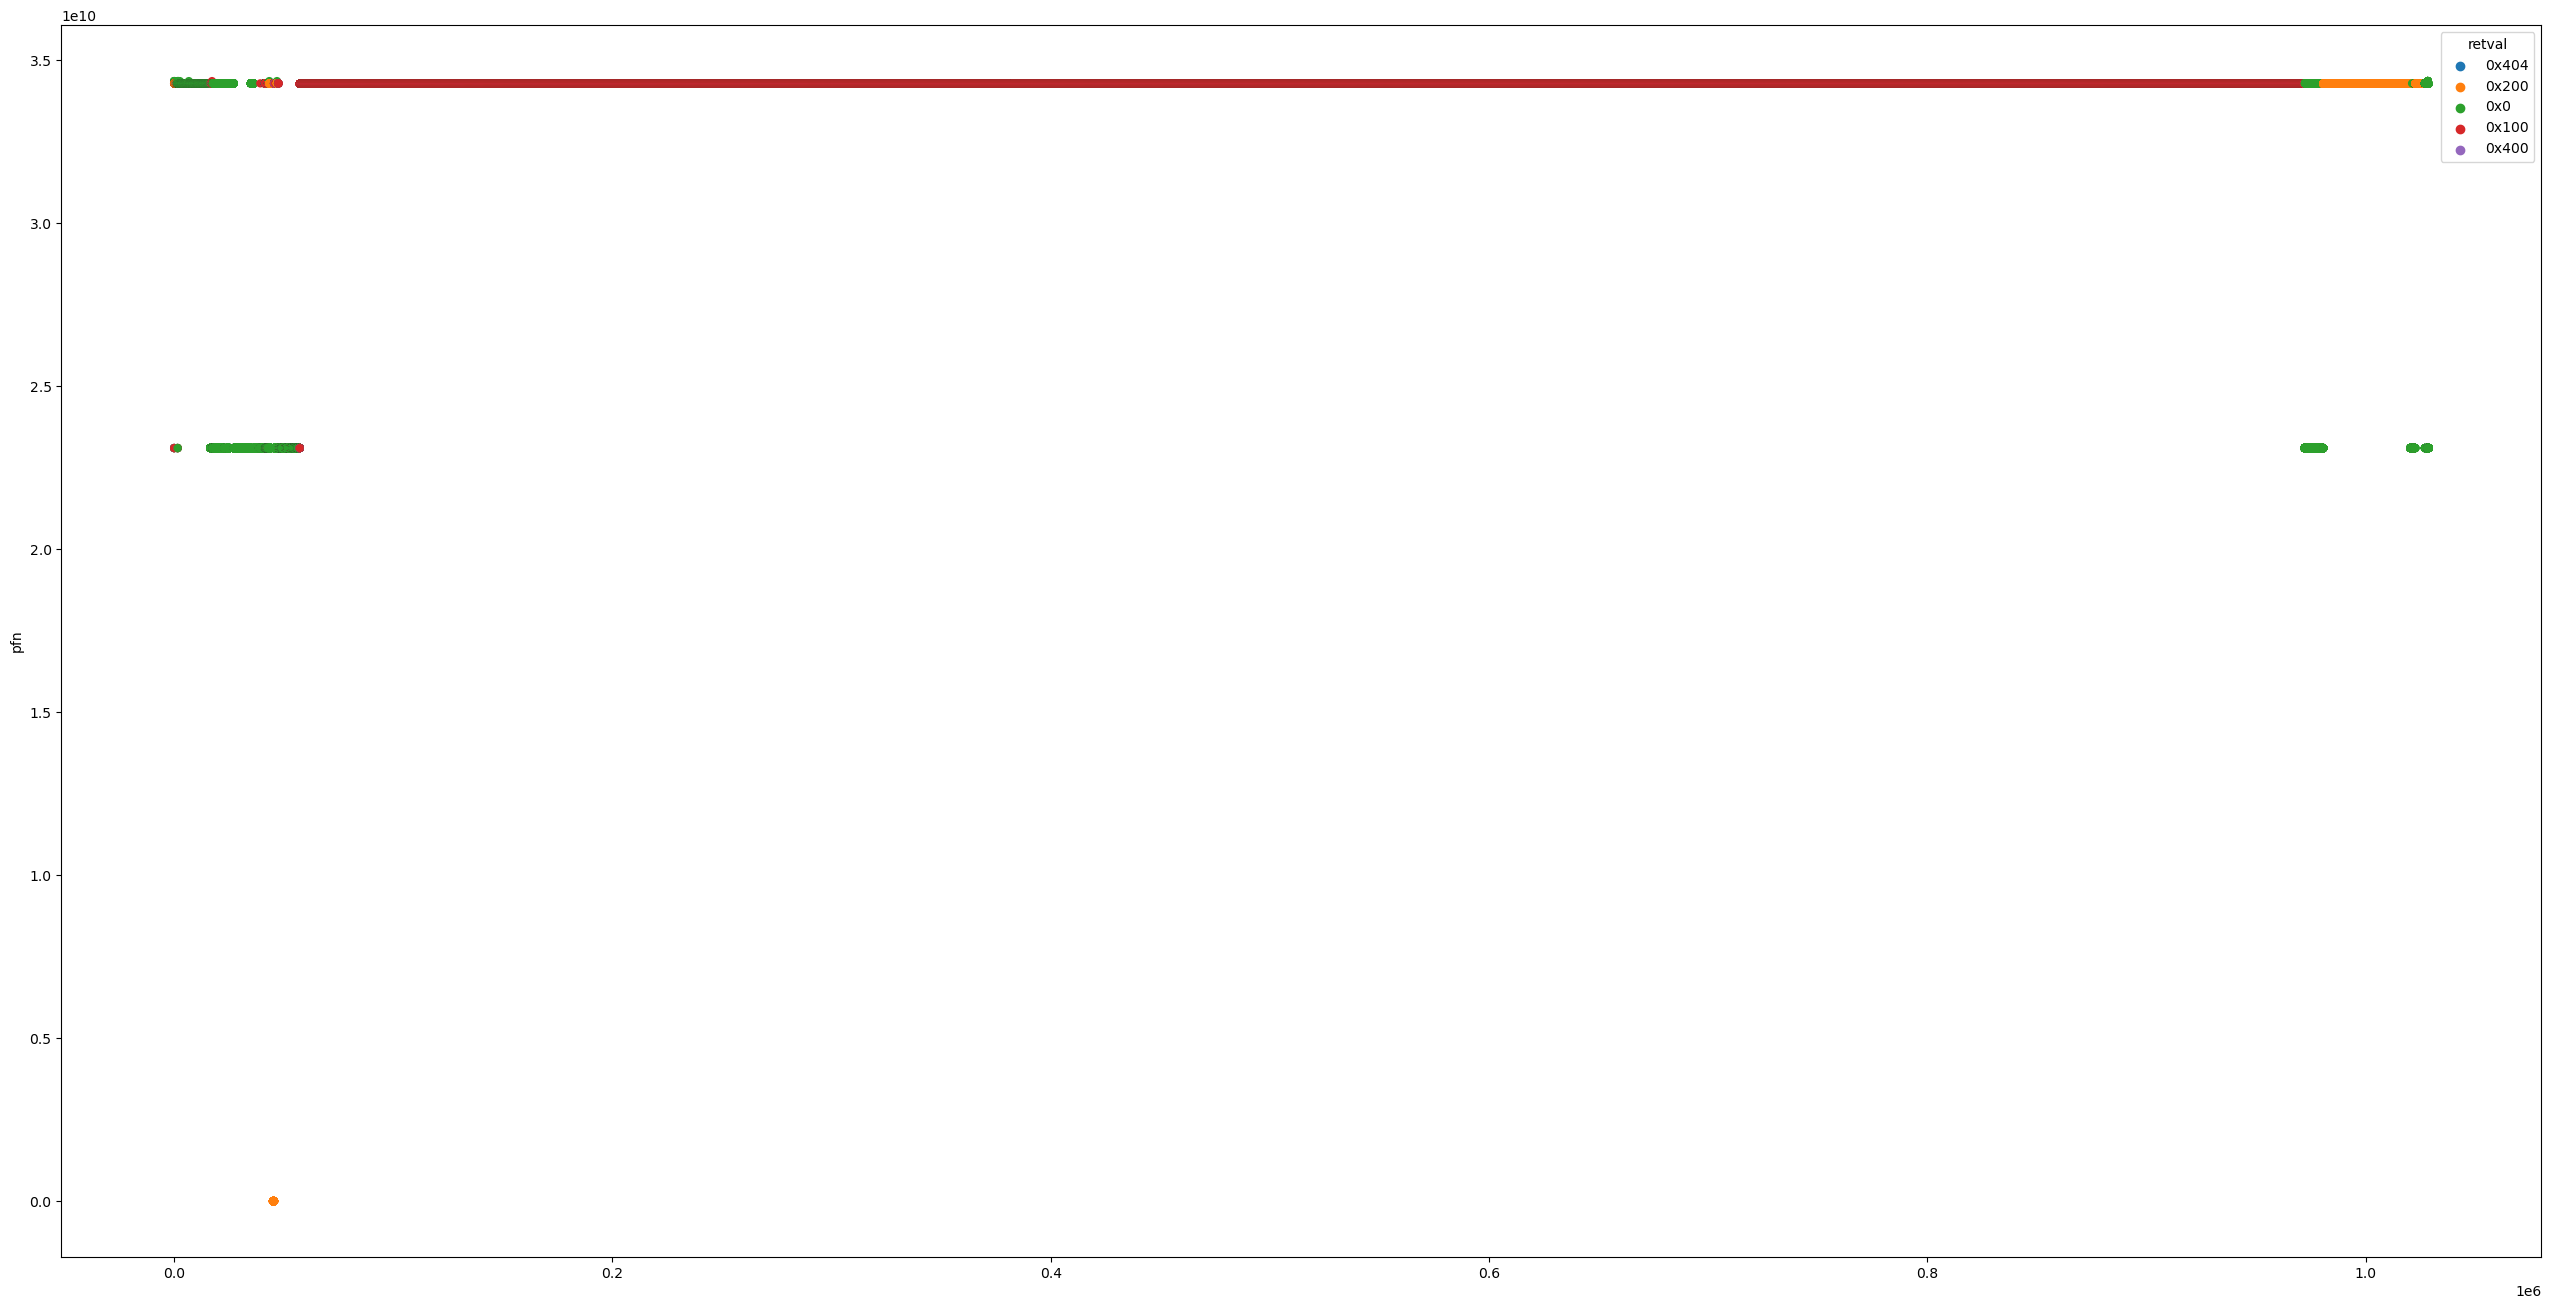

In [13]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(df)), y=df['pfn'], hue=df["retval"], linewidth=0)

In [14]:
kernel_fault = df[df["pfn"] > 3e10]
user_fault = df[(1e10 < df["pfn"]) & (df["pfn"] <= 3e10)]

<Axes: ylabel='pfn'>

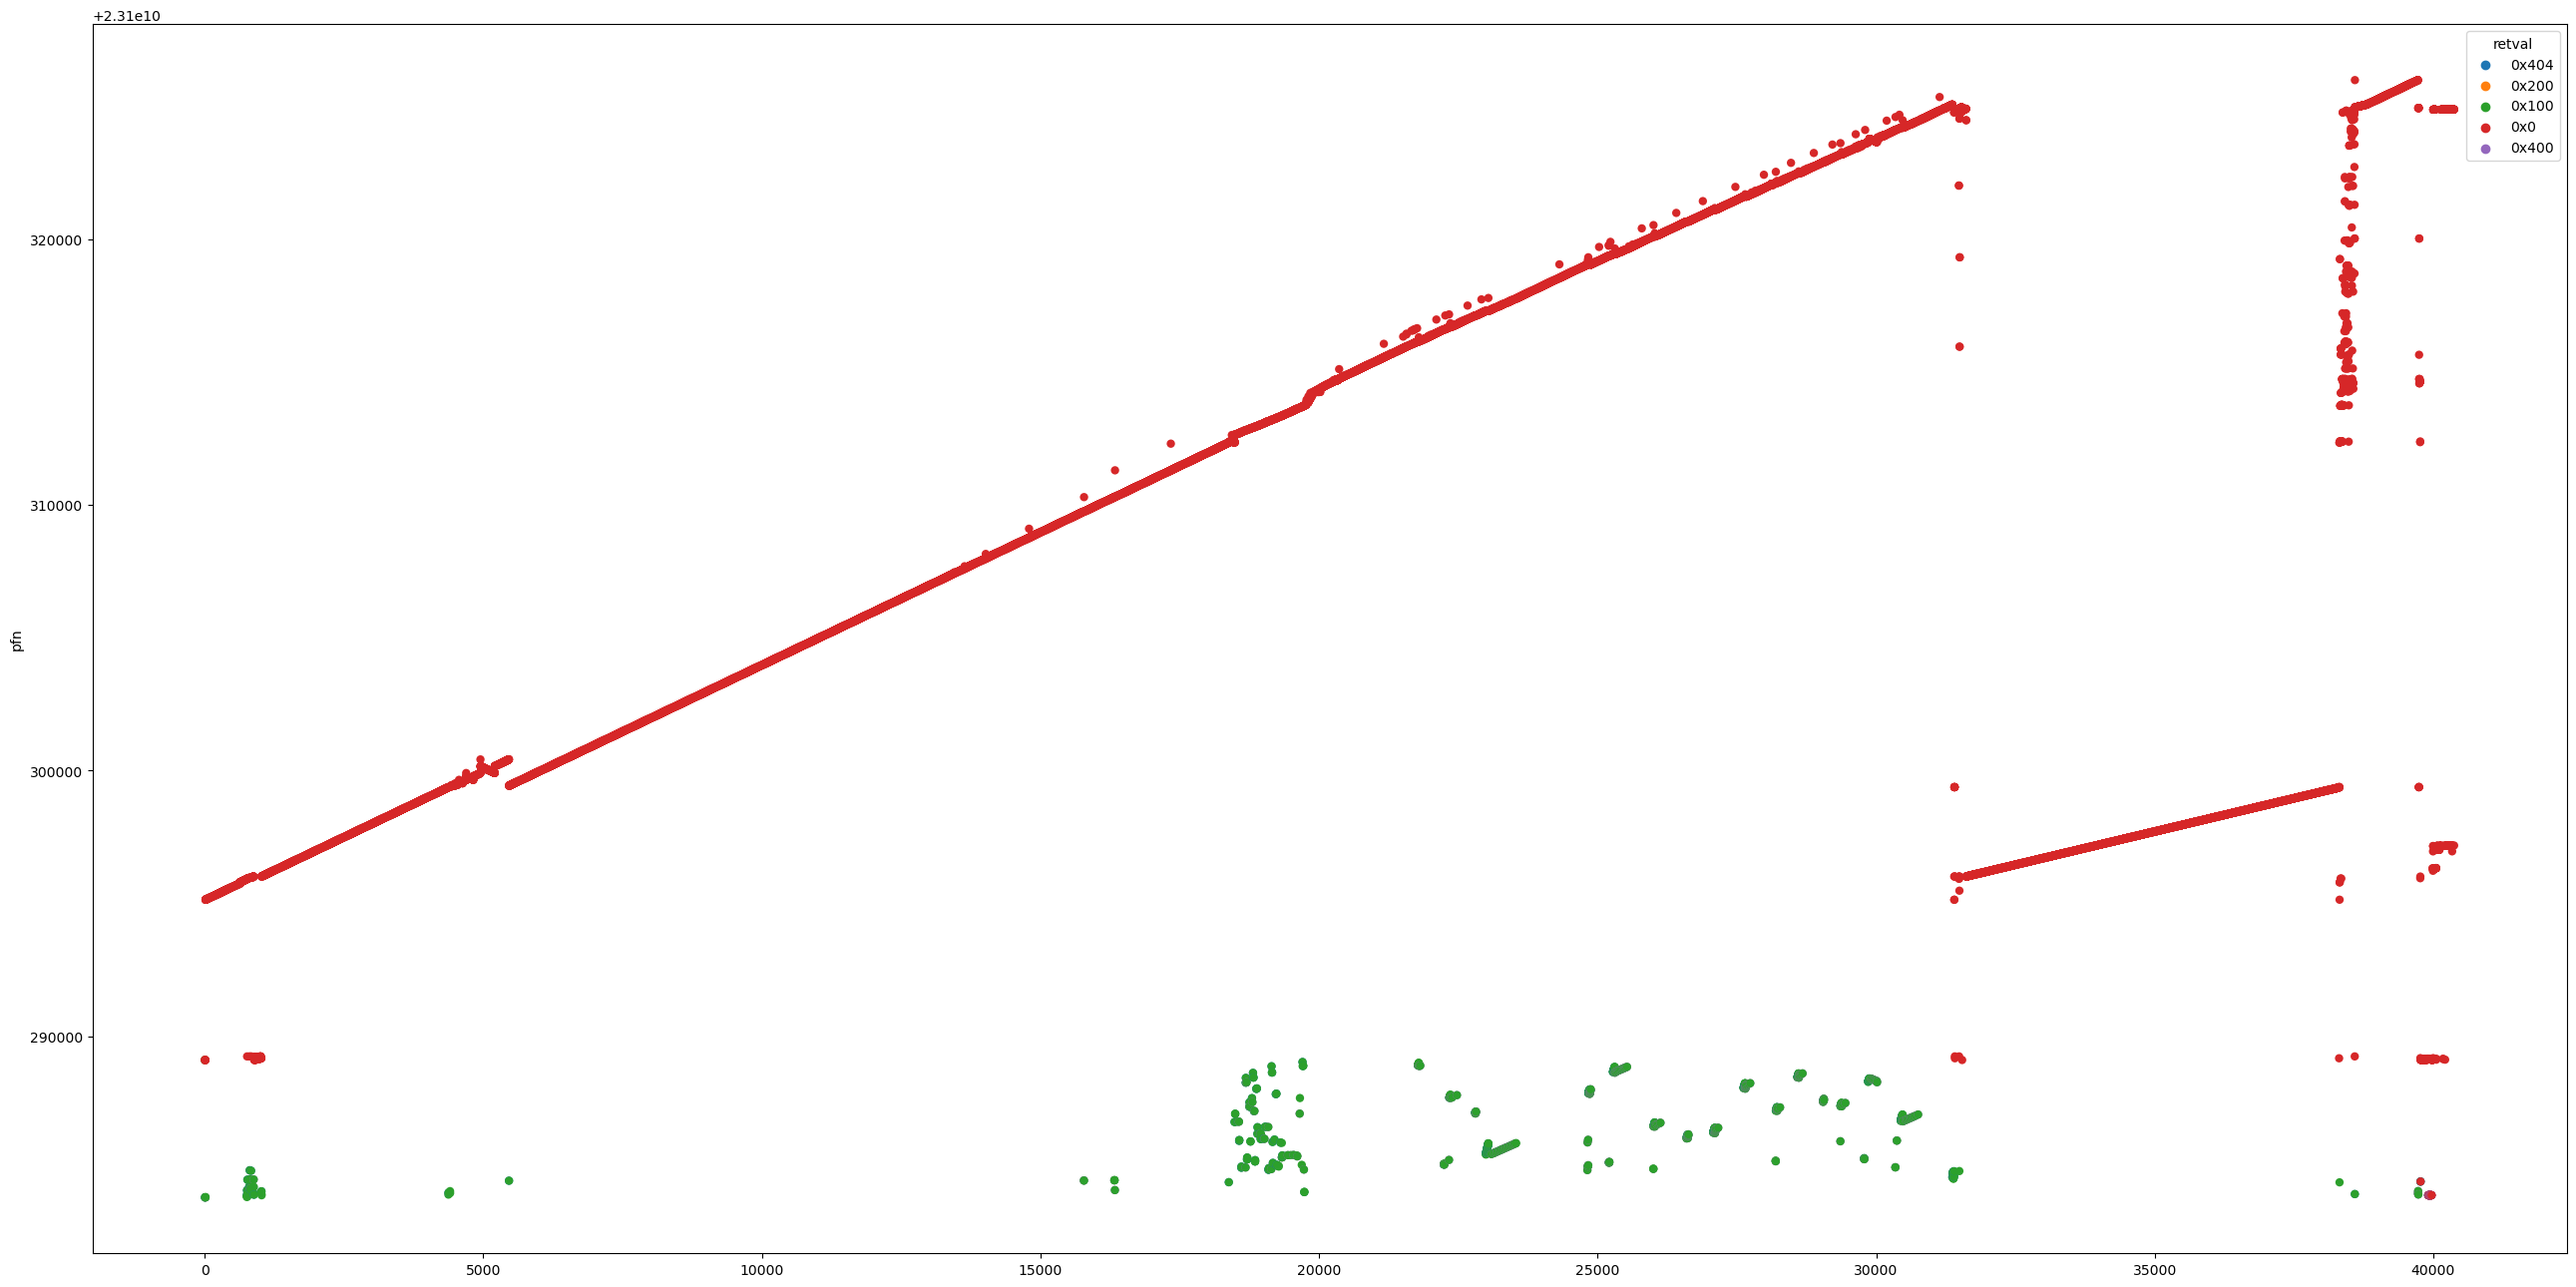

In [15]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault)), y=user_fault['pfn'], hue=user_fault["retval"], linewidth=0)

### 去除一下所有的0x0的fault，也就是非错误处理逻辑

In [16]:
no_zero_retval_fault = user_fault[user_fault["retval"] != "0x0"]

<Axes: ylabel='pfn'>

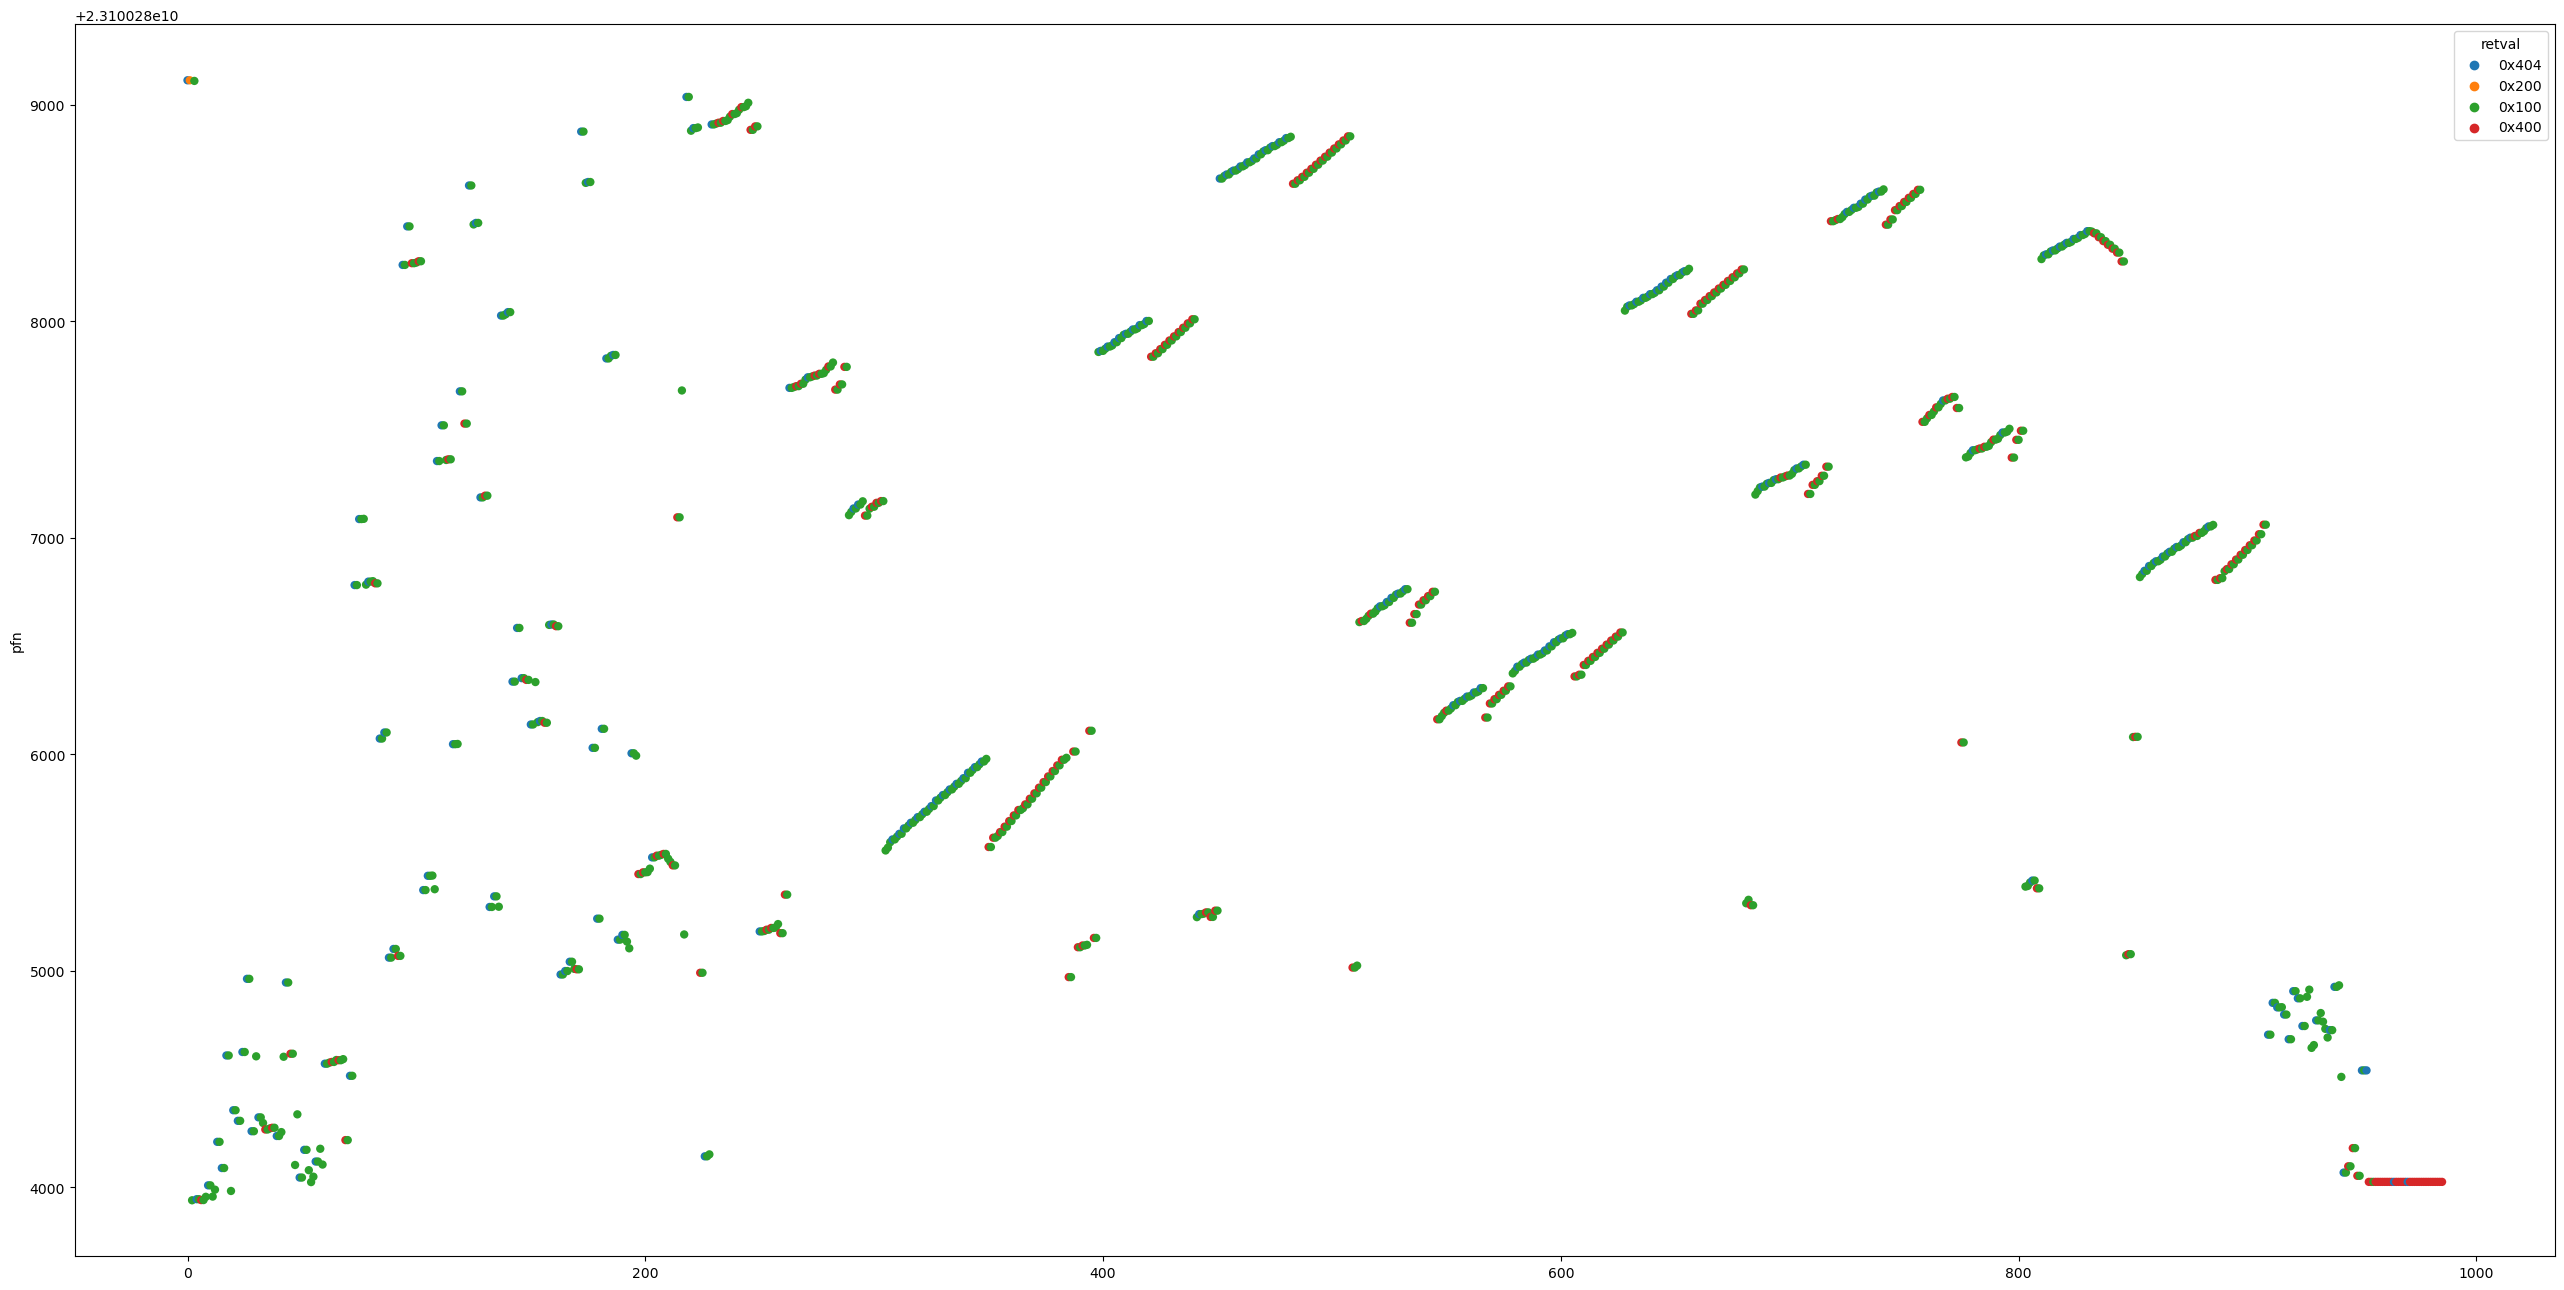

In [17]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(no_zero_retval_fault)), y=no_zero_retval_fault['pfn'], hue=no_zero_retval_fault["retval"], linewidth=0)

### 去除一下所有的0x100的fault，也就是NOPAGE

In [18]:
drop_zero_drop_no_page_retval_fault = user_fault[(user_fault["retval"] != "0x0") & (user_fault["retval"] != "0x100")]

<Axes: ylabel='pfn'>

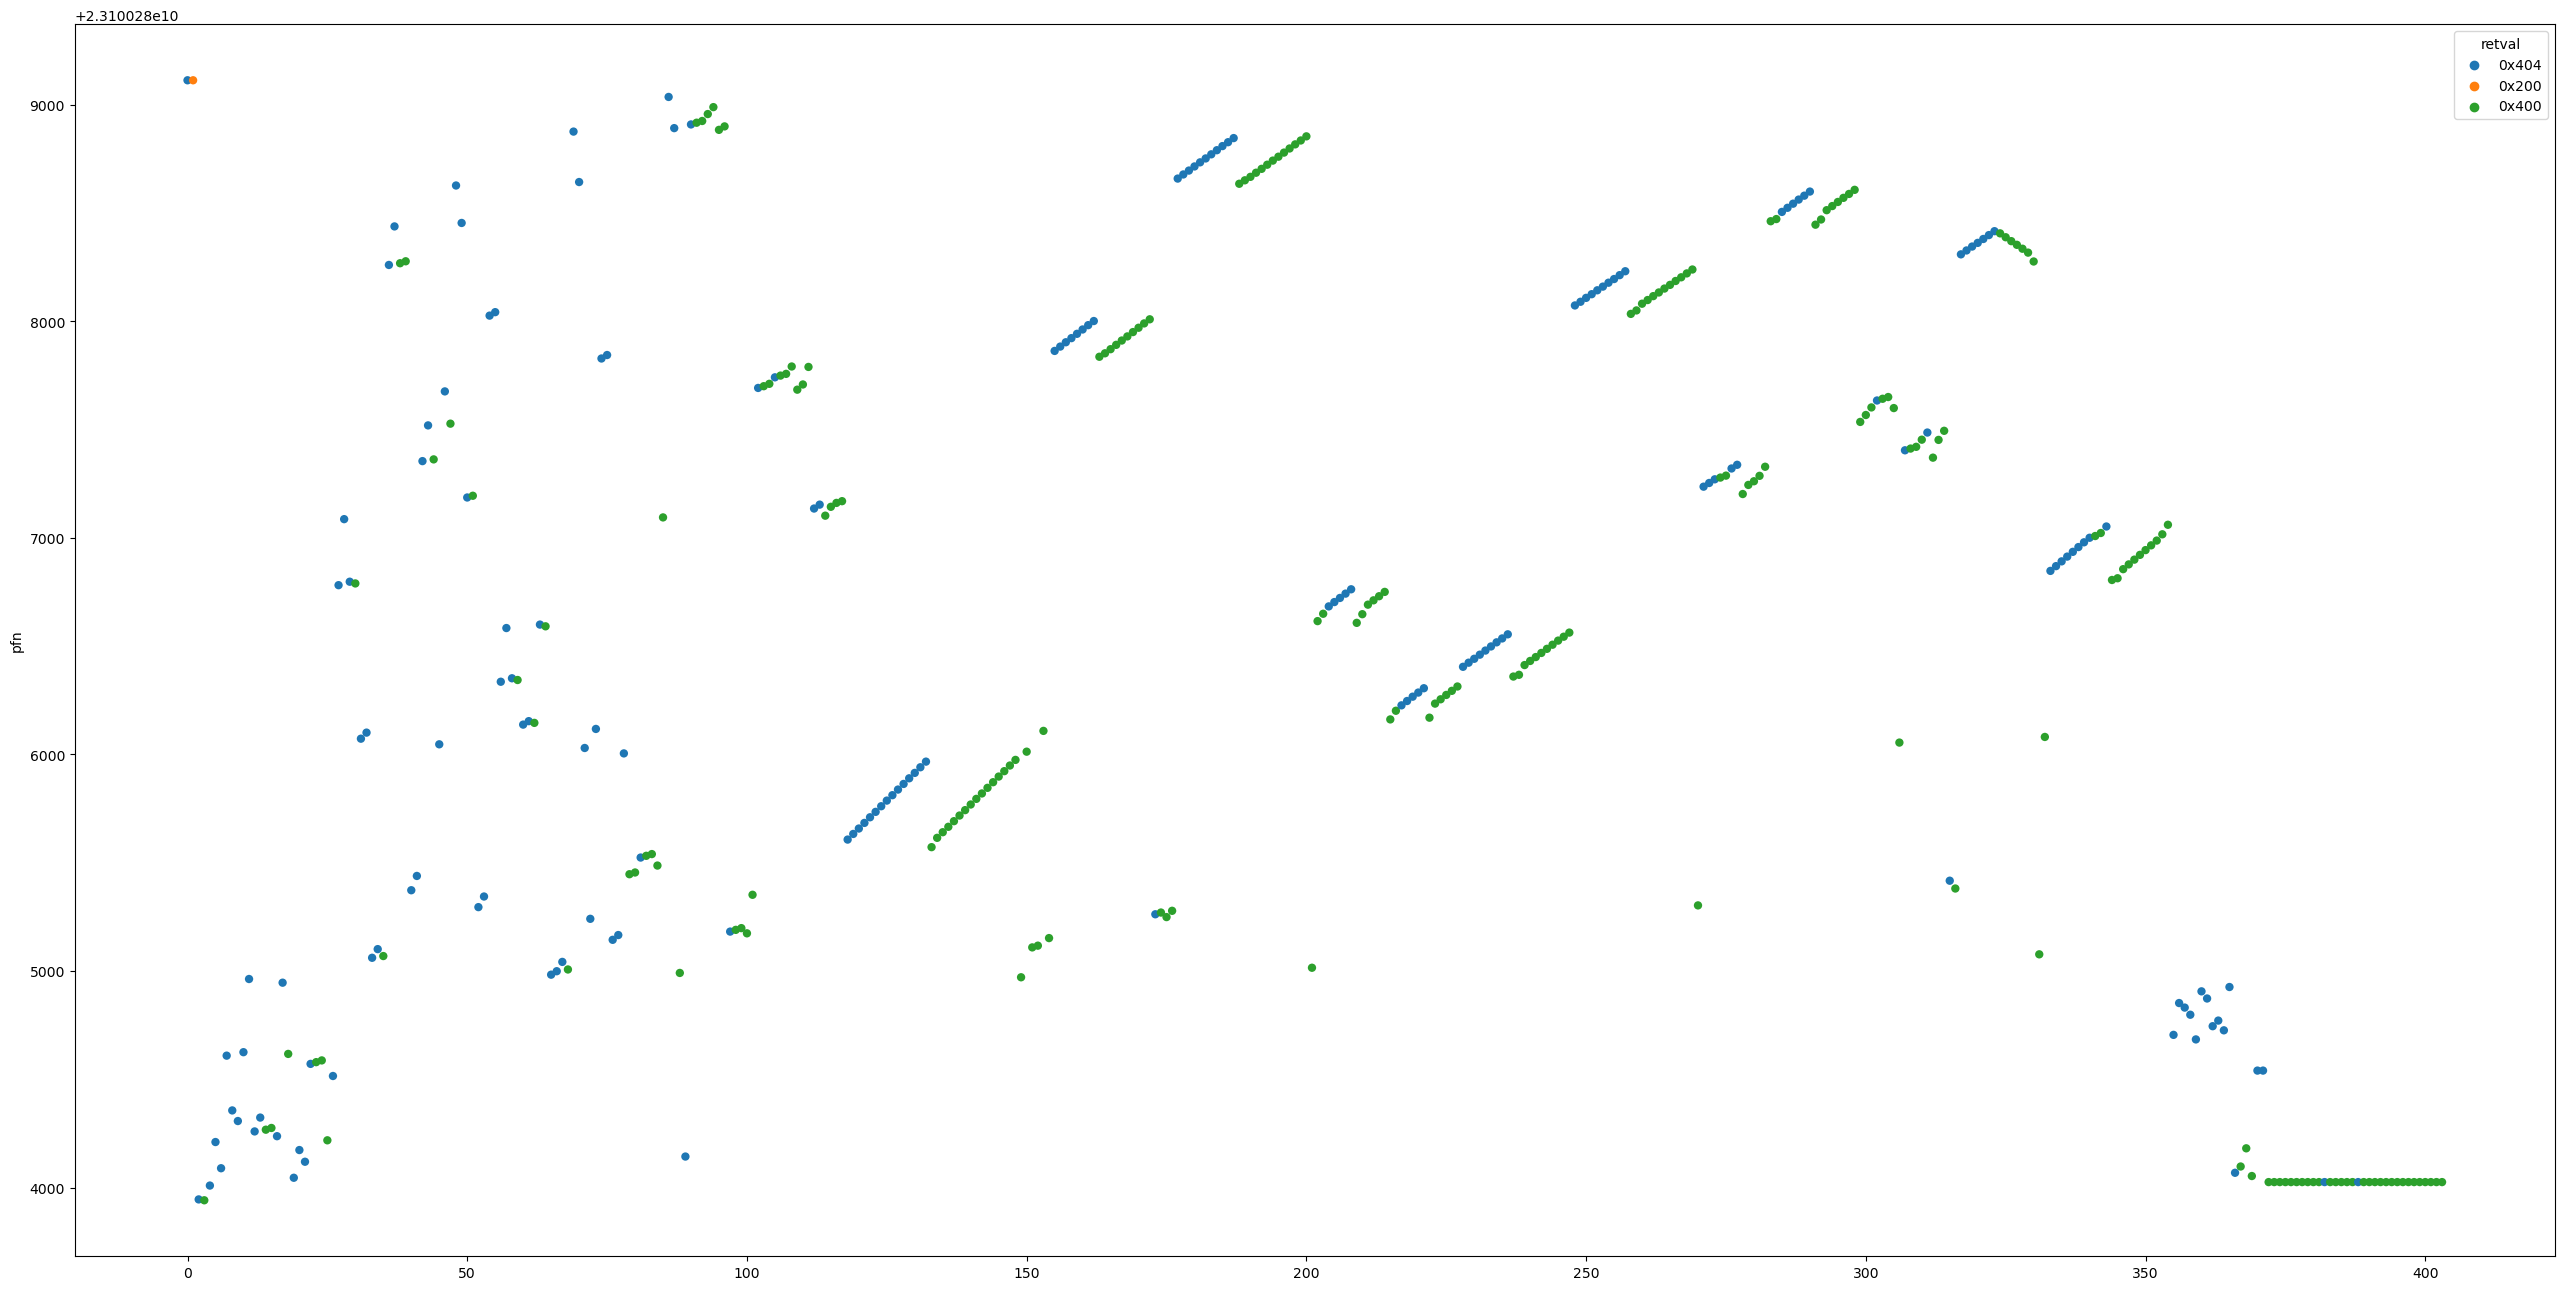

In [19]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(drop_zero_drop_no_page_retval_fault)), y=drop_zero_drop_no_page_retval_fault['pfn'], hue=drop_zero_drop_no_page_retval_fault["retval"], linewidth=0)

In [27]:
bak_df = df
bak_df["count"] = 1
time_cost = bak_df.groupby("retval").sum(["time", "count"])
time_cost["time"] = time_cost["time"].apply(lambda x: x/1e9)
time_cost

,time,pfn,count
retval,,,
0x0,0.110779,1712894851520006,62809
0x100,1.188523,26187700398576519,764094
0x200,0.070803,1638303787512732,48308
0x400,40.904798,5247371525267143,153140
0x404,0.137752,13952818313711,466


In [21]:
df["time"].sum()

42412655377

### 只统计 major fault

In [22]:
fault_major_df = df[(df["retval"] == '0x404') | (df["retval"] == '0x400')]

<Axes: ylabel='pfn'>

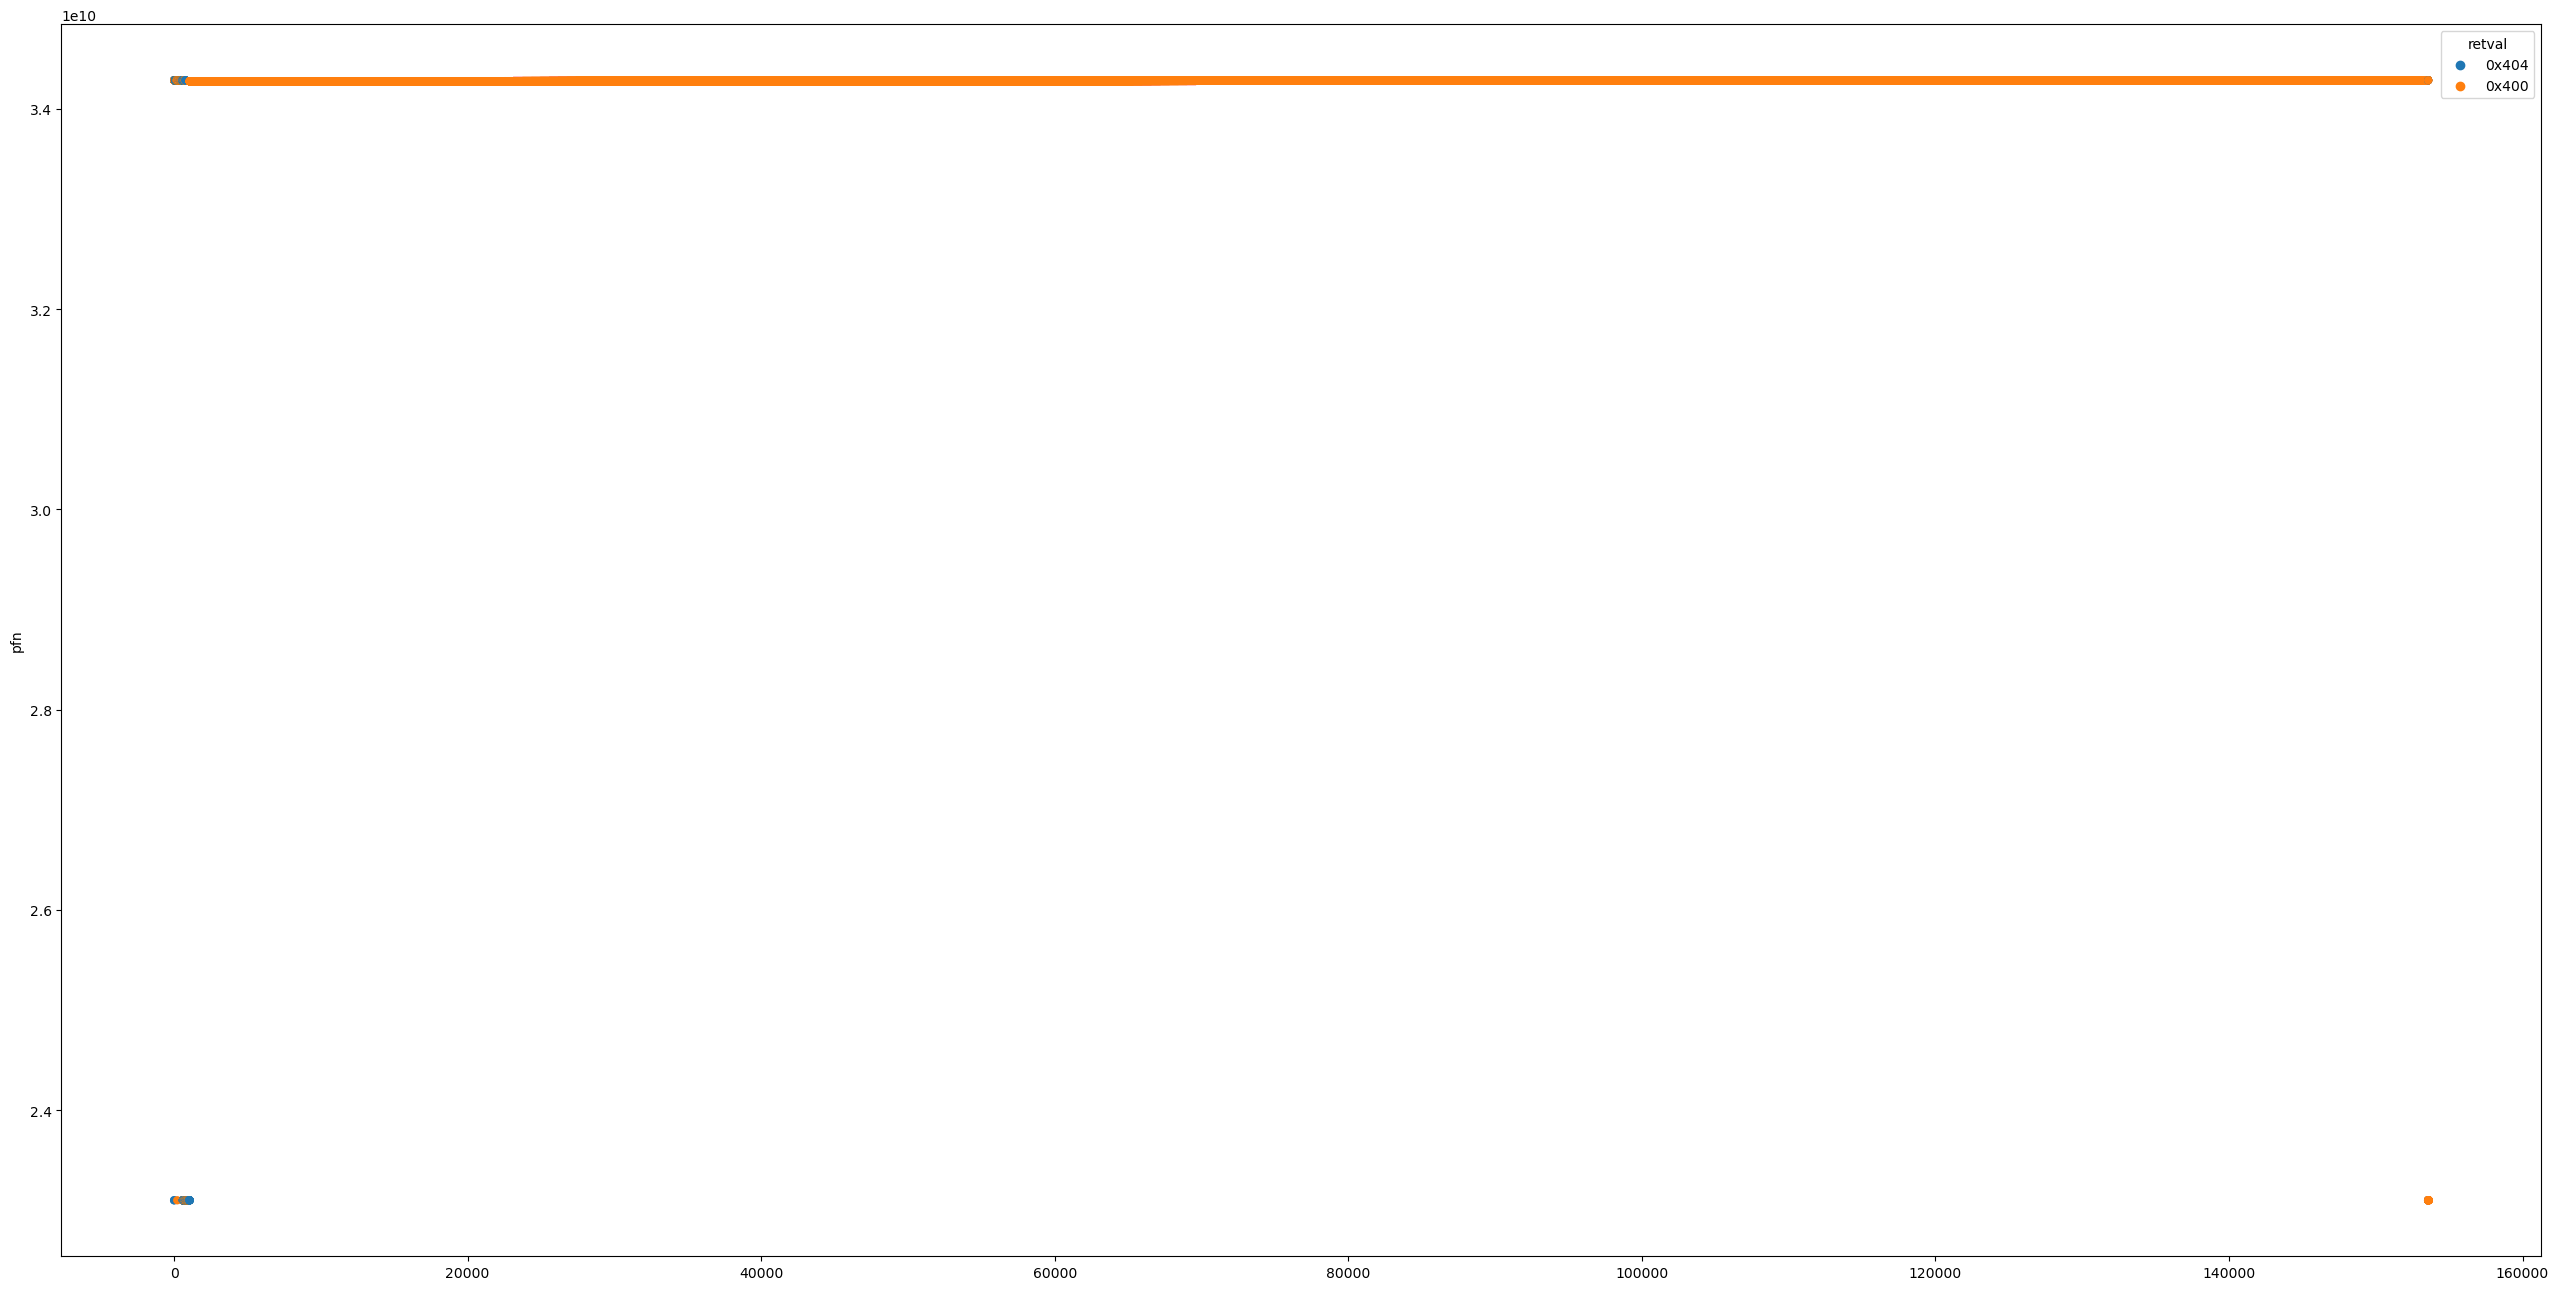

In [23]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(fault_major_df)), y=fault_major_df['pfn'], hue=fault_major_df["retval"], linewidth=0)

In [24]:
kernel_fault_major_df = fault_major_df[fault_major_df["pfn"] > 3e10]
user_fault_major_df = fault_major_df[fault_major_df["pfn"] <= 3e10]


In [25]:
print(len(kernel_fault_major_df))
print(len(user_fault_major_df))

153203
403


In [26]:
kernel_fault_major_df["time"].sum() / 1e9

40.969249747

In [31]:
kernel_fault_major_df["retval"].value_counts()

retval
0x400    152918
0x404       285
Name: count, dtype: int64

In [28]:
df

,pid,name,addr,flags,time,retval,pfn,count
0,3680376,main,0x56102ca5a468,1000010101,508773,0x404,23100289114,1
1,3680376,main,0x56102ca5a468,1000110101,2920,0x200,23100289114,1
2,3680376,main,0x7fbc4ac7e110,1000010101,4950,0x200,34286621310,1
3,3680376,main,0x7ffef6e45919,1000010101,1850,0x0,34356532293,1
4,3680376,main,0x7fbc4ac63290,1101010100,4030,0x100,34286621283,1
...,...,...,...,...,...,...,...,...
1028812,3680376,main,0x56103560c058,1001010100,47600,0x0,23100324876,1
1028813,3680376,main,0x56102e9df060,1001010100,6820,0x0,23100297183,1
1028814,3680376,main,0x7fb24fff72d0,1000010101,12460,0x0,34276156919,1
1028815,3680376,main,0x7fb24f7f62d0,1000010101,5580,0x0,34276154870,1


<Axes: ylabel='pfn'>

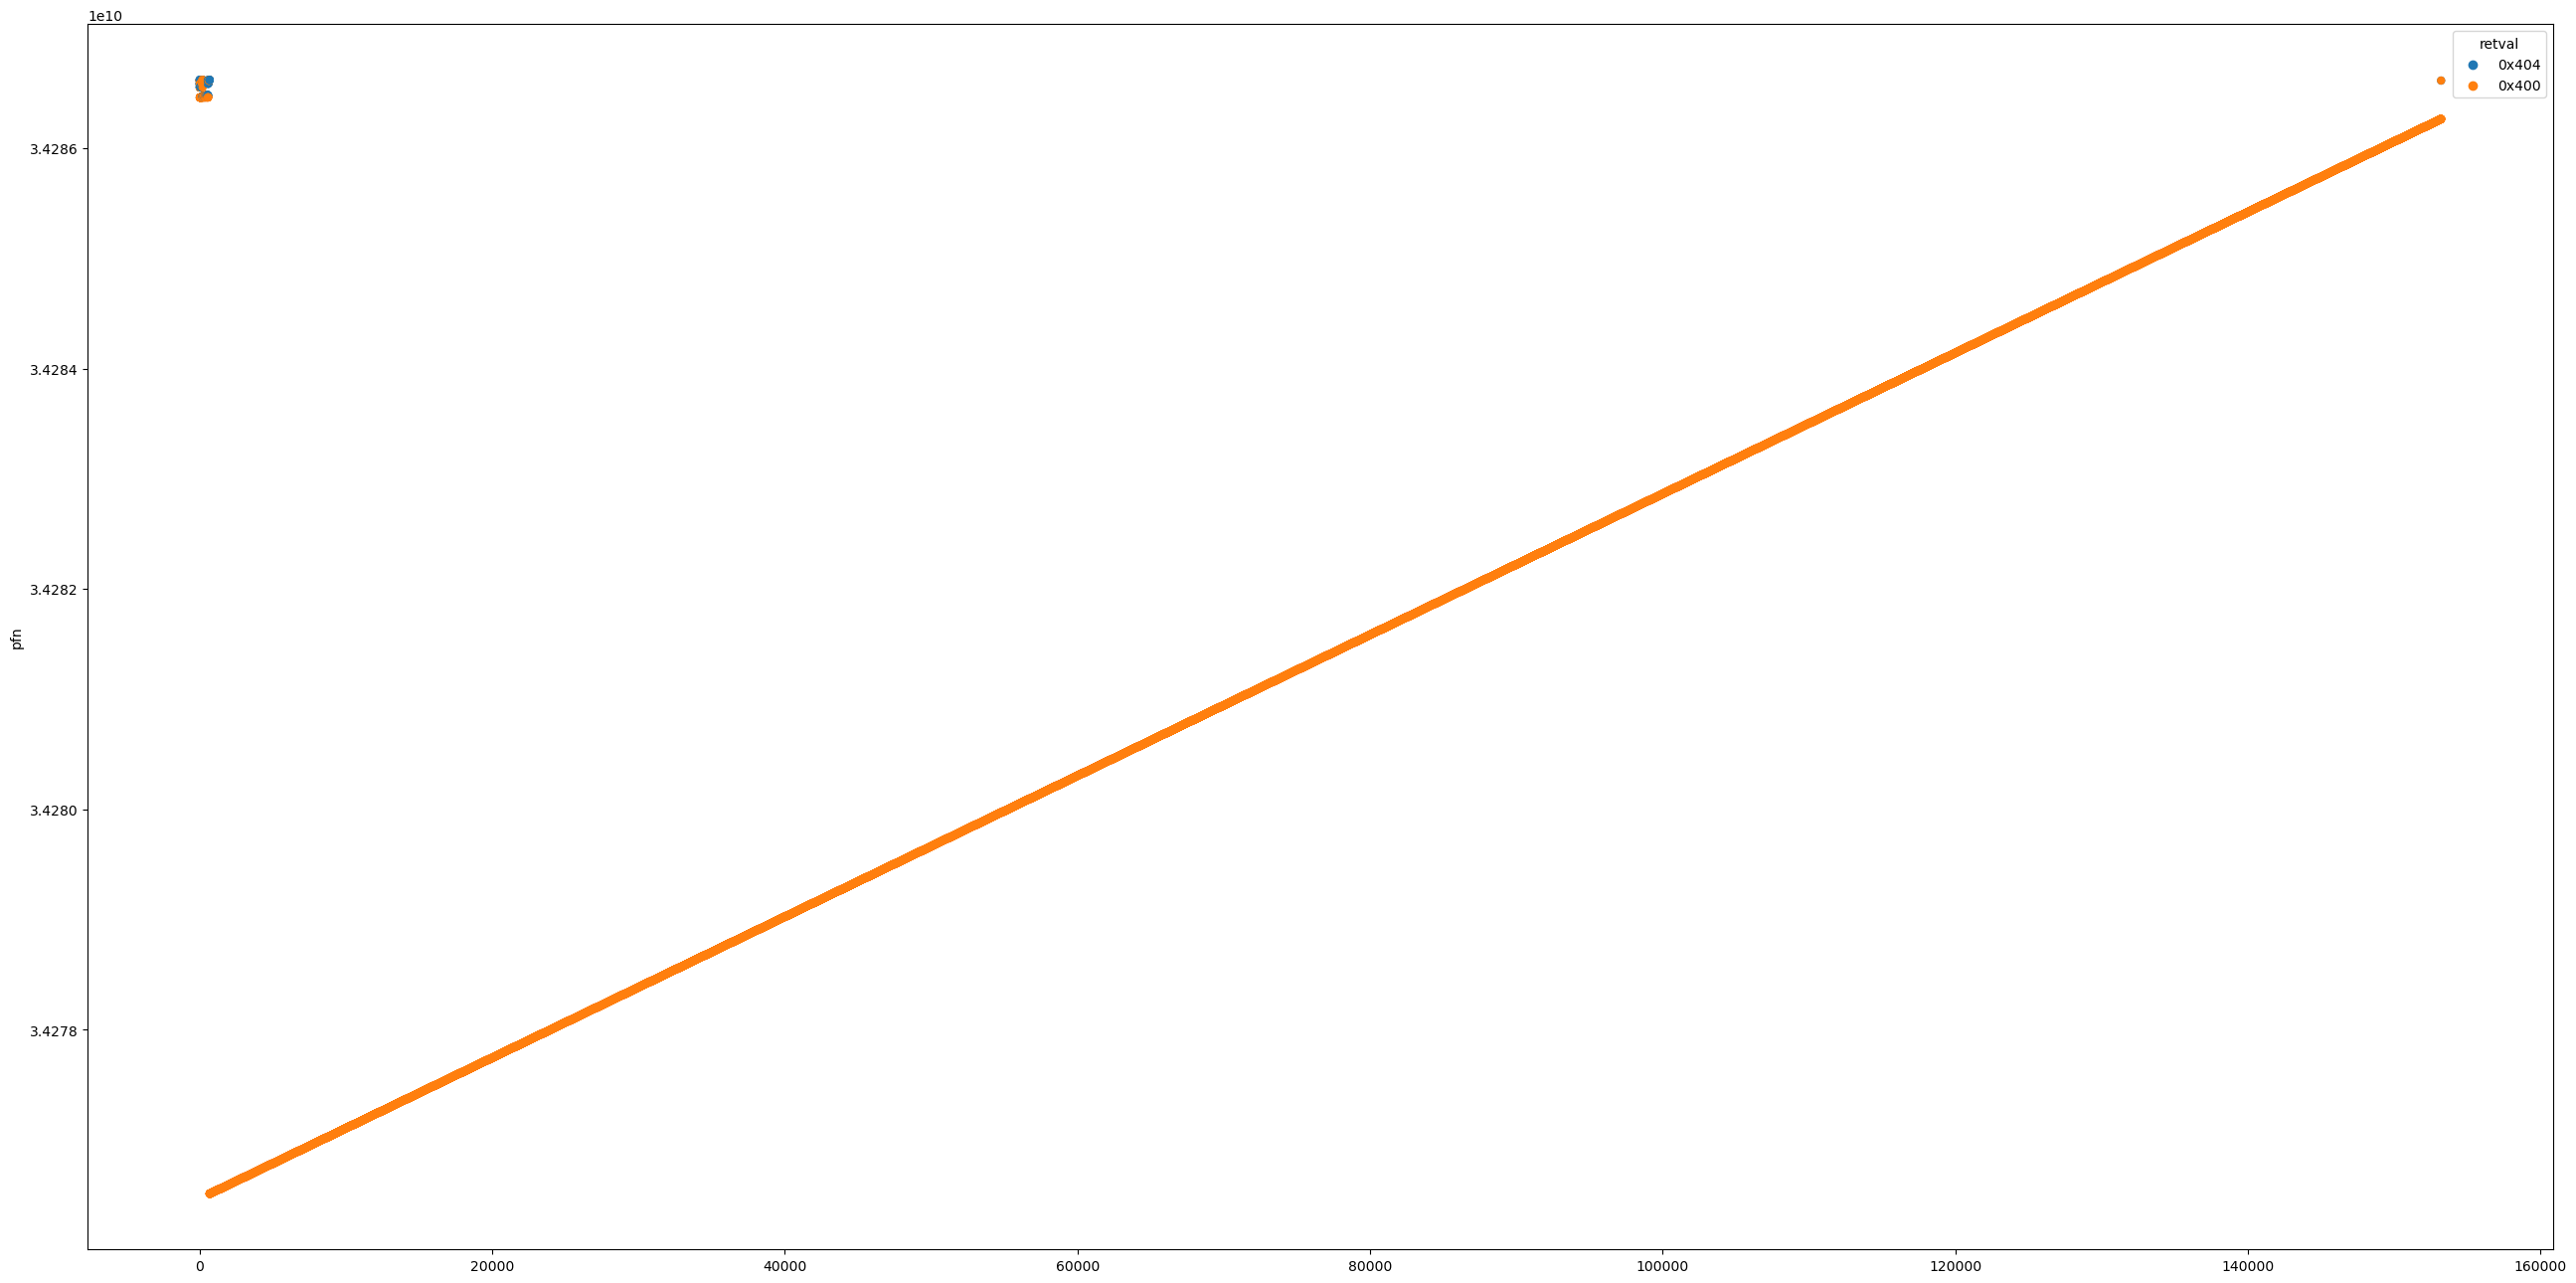

In [29]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(kernel_fault_major_df)), y=kernel_fault_major_df['pfn'], hue=kernel_fault_major_df["retval"], linewidth=0)

<Axes: ylabel='pfn'>

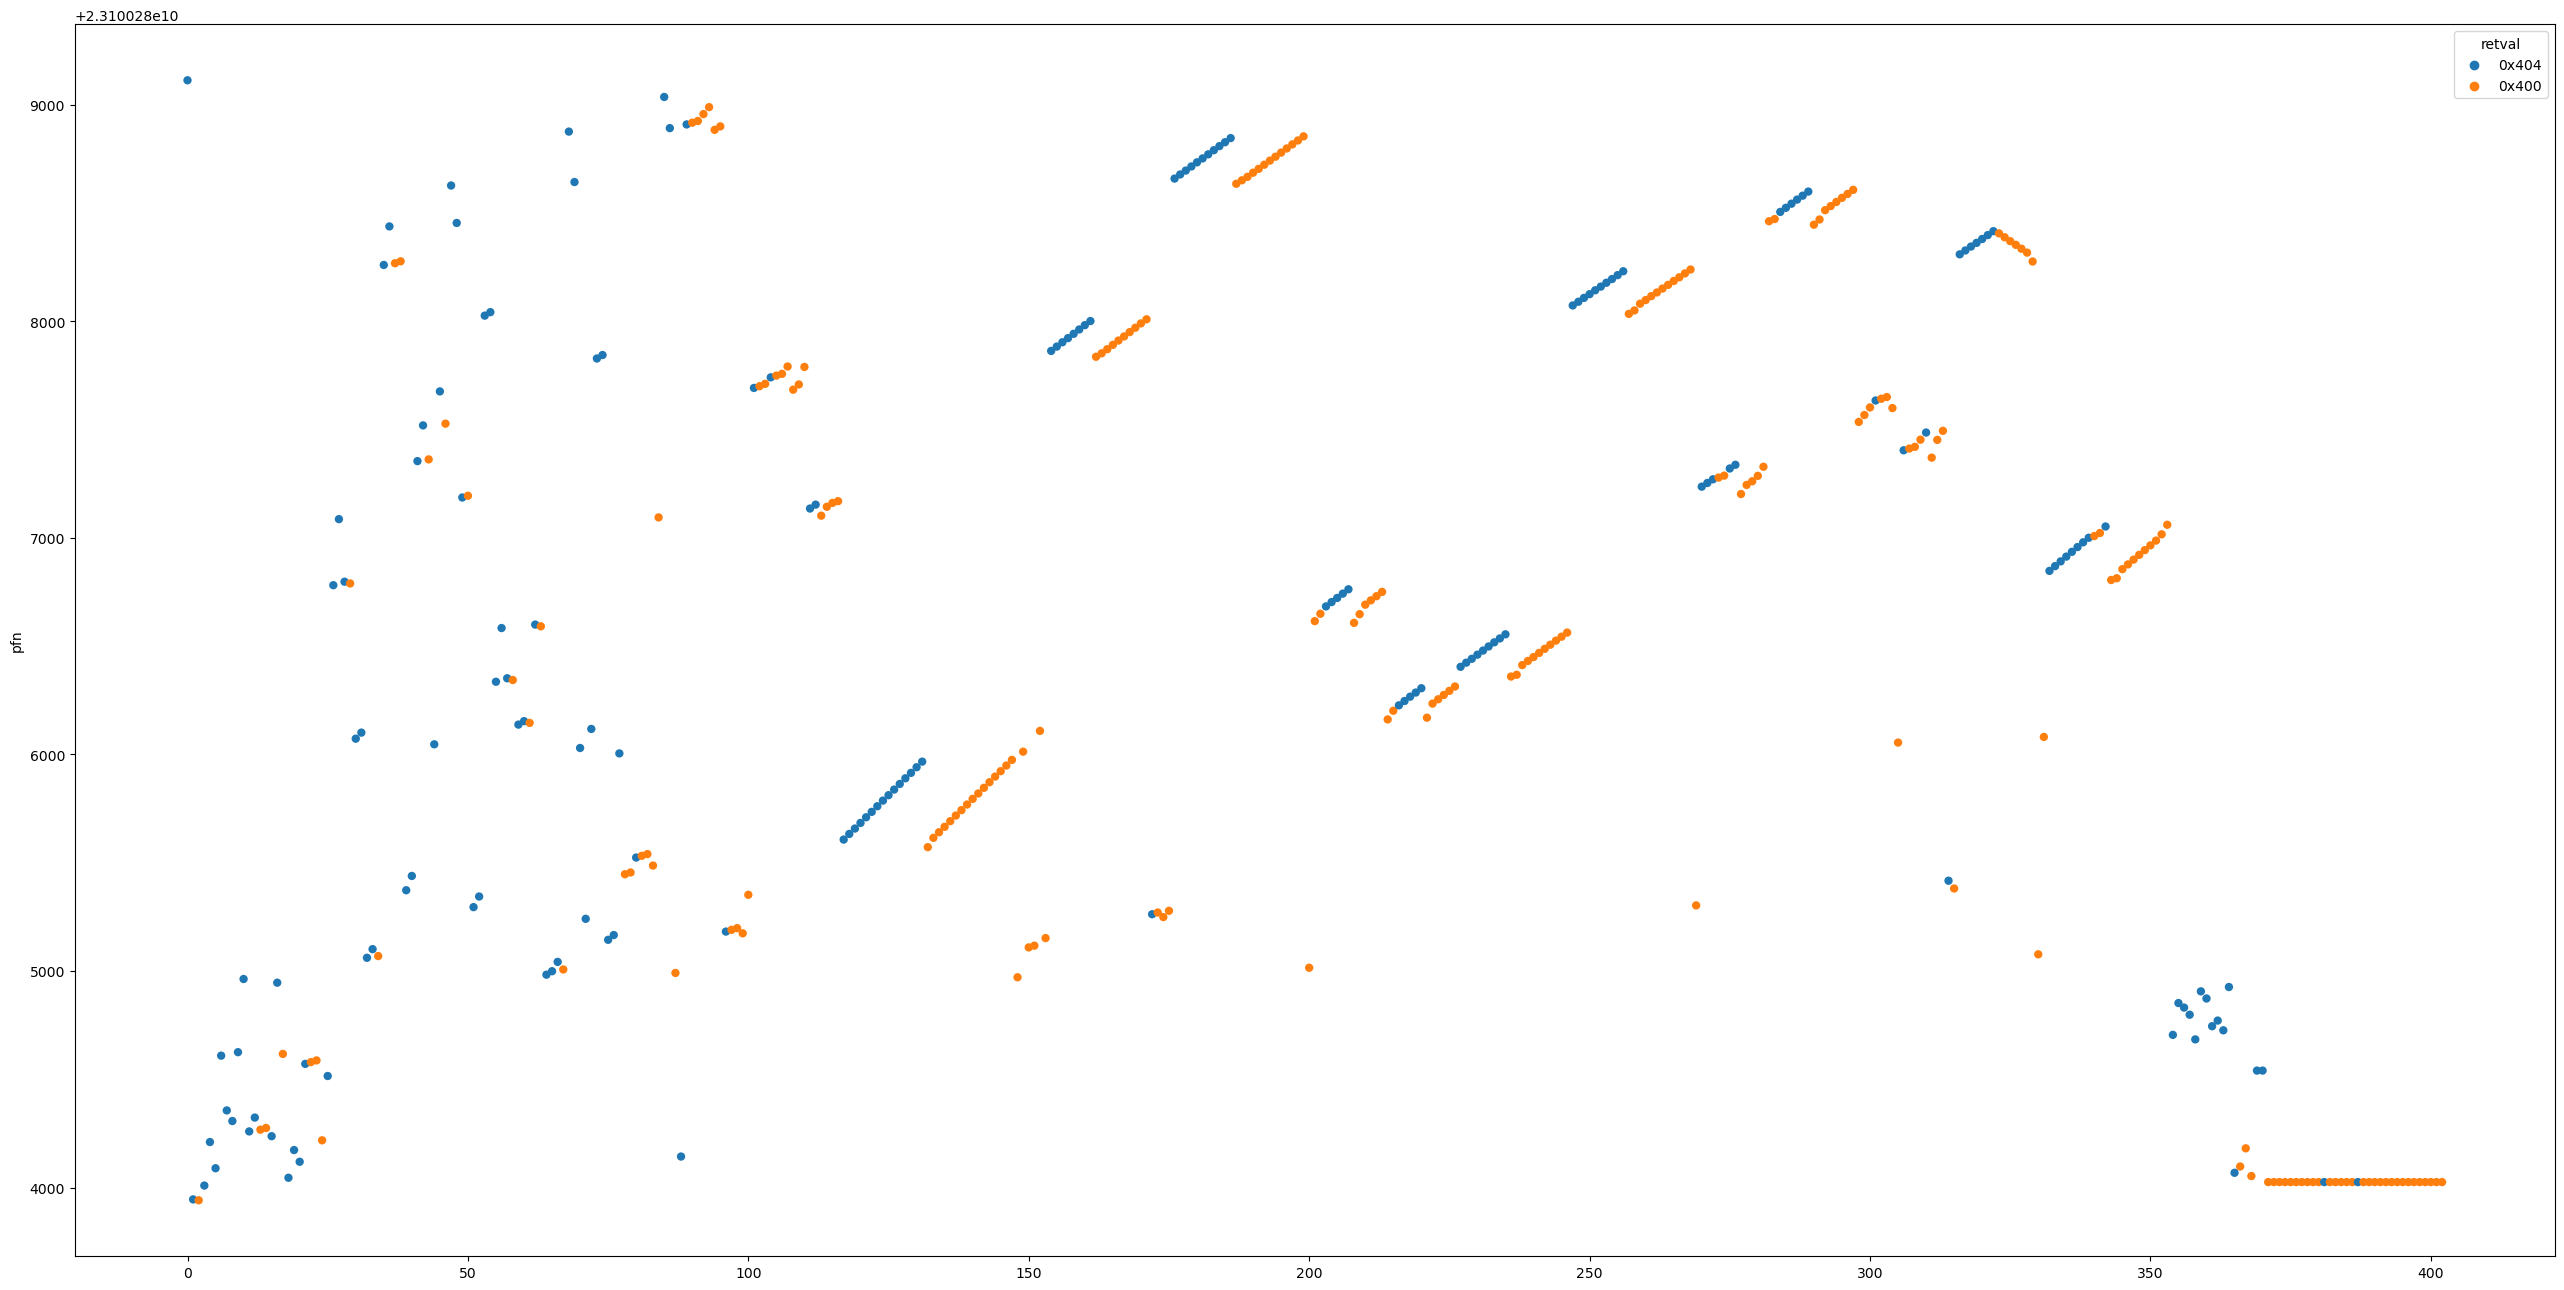

In [30]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault_major_df)), y=user_fault_major_df['pfn'], hue=user_fault_major_df["retval"], linewidth=0)

In [32]:
fault_major_df["retval"].value_counts()

retval
0x400    153140
0x404       466
Name: count, dtype: int64

In [33]:
fault_major_df["time"].sum()/1e9

41.042550264

In [39]:
tmp = fault_major_df.copy()
tmp["count"] = 1
r = tmp[["retval", "time", "count"]].groupby("retval").sum()
r["time"] = r["time"].apply(lambda x: x/1e9)
r

,time,count
retval,,
0x400,40.904798,153140
0x404,0.137752,466
